In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

import copy
import random

from ECGDataset import ECGDataset

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
window_size = 180
train_ds= ECGDataset(f"data/normal_train_{window_size}_cleaned.csv", f"data/train_labels_{window_size}_cleaned.csv")
test_normal_ds = ECGDataset(f"data/normal_test{window_size}_cleaned.csv", f"data/normal_labels_{window_size}_cleaned.csv")
test_anomalie_ds = ECGDataset(f"data/anomalie_test{window_size}_cleaned.csv", f"data/anomalie_labels_{window_size}_cleaned.csv")
val_ds = ECGDataset(f"data/normal_val_{window_size}_cleaned.csv", f"data/val_labels_{window_size}_cleaned.csv")


In [4]:
train_ds.y

[['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],


['N']

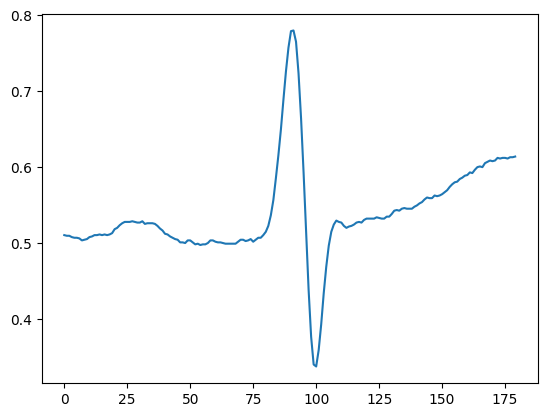

In [5]:
plt.plot(train_ds.df[0])
train_ds.y[0]

['N']

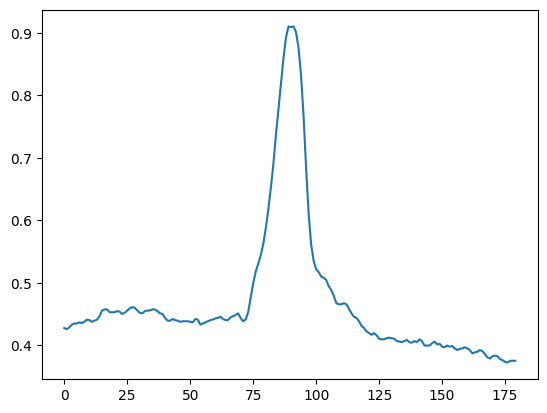

In [6]:
plt.plot(test_normal_ds.df[12])
test_normal_ds.y[12]

In [7]:
def train_model(model, train_dataset, val_dataset, n_epochs, lr, batch_size):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    val_losses = []

    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset)

    size = len(train_dl.dataset)
    for batch, (X,y) in enumerate(train_dl):
        # Compute prediction and loss
        X = X.to(device)
        pred = model(X)
        loss = criterion(pred, X)
        train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10000 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    with torch.no_grad():  # requesting pytorch to record any gradient for this block of code
      for (seq_true, y) in val_dl:
        seq_true = seq_true.to(device)   # putting sequence to gpu
        seq_pred = model(seq_true)    # prediction

        loss = criterion(seq_pred, seq_true)  # recording loss

        val_losses.append(loss.item())    # storing loss into the validation losses

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f'Epoch {epoch}: train loss = {train_loss}, val loss = {val_loss}')

  return model.eval(), history

In [8]:
from lstmae import RecurrentAutoencoder

model = RecurrentAutoencoder(180, 1, device, 32)
model = model.to(device)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [13]:
model(train_ds.__getitem__(0)[0].to(device)).shape

torch.Size([1, 180, 1])

In [14]:
model, history = train_model(
  model, 
  train_dataset=train_ds, 
  val_dataset=val_ds,
  n_epochs=30,
  lr=5e-4,
  batch_size=1
)

loss: 55.891609  [    1/71253]
loss: 6.048369  [10001/71253]
loss: 3.502351  [20001/71253]
loss: 4.764980  [30001/71253]
loss: 3.808388  [40001/71253]
loss: 5.964246  [50001/71253]
loss: 9.536087  [60001/71253]
loss: 2.139974  [70001/71253]
Epoch 1: train loss = 5.0651052927697515, val loss = 3.3538126385130647
loss: 2.150208  [    1/71253]
loss: 4.661994  [10001/71253]
loss: 3.691947  [20001/71253]
loss: 3.728639  [30001/71253]
loss: 2.319834  [40001/71253]
loss: 2.511839  [50001/71253]
loss: 2.309407  [60001/71253]
loss: 1.250574  [70001/71253]
Epoch 2: train loss = 3.2756515042769414, val loss = 2.6095592665021905
loss: 2.892339  [    1/71253]
loss: 1.777890  [10001/71253]
loss: 3.051629  [20001/71253]
loss: 2.282655  [30001/71253]
loss: 1.549726  [40001/71253]
loss: 3.268859  [50001/71253]
loss: 1.328529  [60001/71253]
loss: 1.619565  [70001/71253]
Epoch 3: train loss = 2.580854656717132, val loss = 2.158873582517116
loss: 2.396686  [    1/71253]
loss: 1.934835  [10001/71253]
loss:

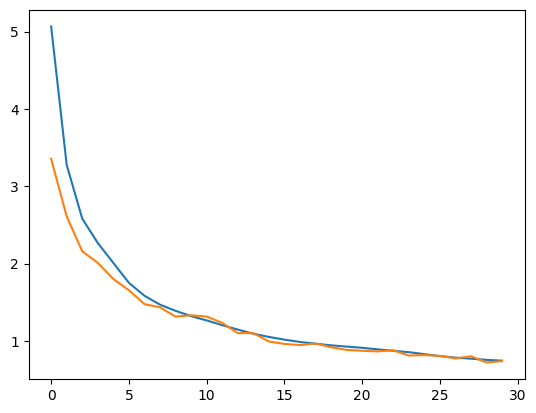

In [15]:
plt.plot(history["train"])
plt.plot(history["val"])

In [16]:
torch.save(model.state_dict(), "models/lstmae_180_embed32.pth")

In [9]:
model.load_state_dict(torch.load("models/lstmae_180_embed32.pth", map_location=torch.device('cpu')))
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [10]:
model = model.to(device="cpu")

In [11]:
train_ds.__getitem__(0)

(tensor([[0.5104],
         [0.5096],
         [0.5096],
         [0.5078],
         [0.5070],
         [0.5070],
         [0.5061],
         [0.5035],
         [0.5043],
         [0.5052],
         [0.5078],
         [0.5087],
         [0.5104],
         [0.5104],
         [0.5113],
         [0.5104],
         [0.5113],
         [0.5104],
         [0.5113],
         [0.5130],
         [0.5183],
         [0.5200],
         [0.5235],
         [0.5261],
         [0.5278],
         [0.5278],
         [0.5278],
         [0.5287],
         [0.5278],
         [0.5270],
         [0.5270],
         [0.5287],
         [0.5252],
         [0.5261],
         [0.5261],
         [0.5261],
         [0.5252],
         [0.5226],
         [0.5191],
         [0.5165],
         [0.5122],
         [0.5113],
         [0.5087],
         [0.5070],
         [0.5052],
         [0.5043],
         [0.5009],
         [0.5009],
         [0.5000],
         [0.5035],
         [0.5035],
         [0.5009],
         [0.

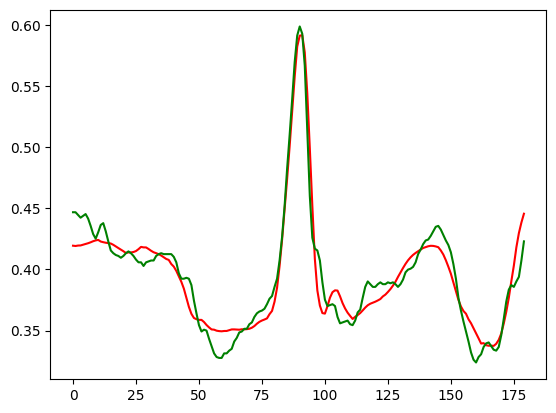

In [12]:
plt.plot(model(test_normal_ds.__getitem__(1)[0]).cpu().detach().numpy().squeeze(), color="red")
plt.plot(test_normal_ds.__getitem__(1)[0].cpu().detach().numpy().squeeze(), color="green")

In [13]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true, y in dataset:
            seq_true = seq_true.to(device).unsqueeze(0)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

In [14]:
model = model.to(device)

In [15]:
_, losses_test_normal = predict(model, test_normal_ds)

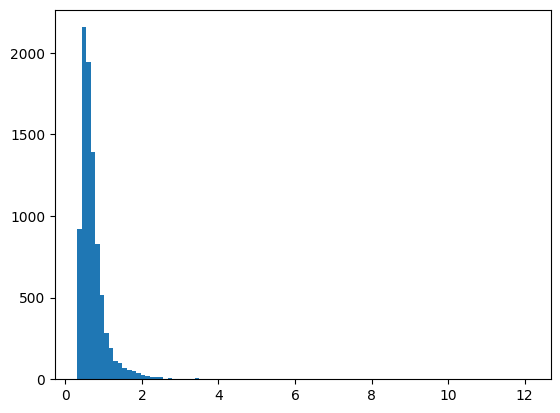

In [16]:
plt.hist(losses_test_normal, bins=100)
plt.show()

In [17]:
THRESHOLD = 2.5

In [18]:
correct = sum(l <= THRESHOLD for l in losses_test_normal)
print(f'Correct normal predictions: {correct}/{len(test_normal_ds)} or  {correct/len(test_normal_ds)}')

Correct normal predictions: 8741/8797 or  0.9936341934750483


In [19]:
_, losses_test_anomaly = predict(model, test_anomalie_ds)

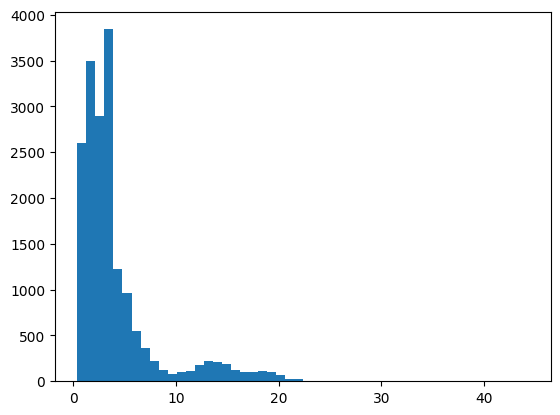

In [20]:
plt.hist(losses_test_anomaly, bins=50)
plt.show()

In [21]:
correct = sum(l > THRESHOLD for l in losses_test_anomaly)
print(f'Correct anomaly predictions: {correct}/{len(test_anomalie_ds)} or  {correct/len(test_anomalie_ds)}')

Correct anomaly predictions: 10771/18040 or  0.5970620842572062


In [22]:
def find_threshold(loss_normal, loss_anomaly):
    threshold_list = np.linspace(0,5,51)
    corr_normal = []
    corr_anomaly = []
    for th in threshold_list:
        corr_normal.append(sum(l <= th for l in loss_normal)/len(loss_normal))
        corr_anomaly.append(sum(l > th for l in loss_anomaly)/len(loss_anomaly))
    return corr_normal, corr_anomaly

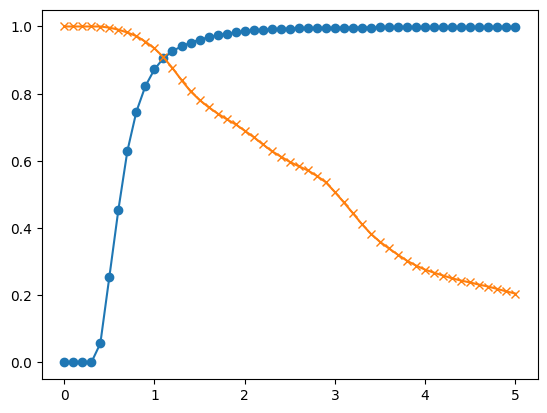

In [23]:
p1, p2= find_threshold(losses_test_normal, losses_test_anomaly)
plt.plot(np.linspace(0,5,51), p1, marker="o")
plt.plot(np.linspace(0,5,51), p2, marker="x")

In [24]:
def predict_classes(model, dataset, threshold=2):
    predictions, losses = [], []
    criterion = torch.nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true, y in dataset:
            seq_true = seq_true.to(device).unsqueeze(0)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)
            pred = "N" if loss <= threshold else "A"
            predictions.append(pred)
            losses.append(loss.item())
    return predictions

In [25]:
from sklearn import metrics
    
pred_normal = predict_classes(model, test_normal_ds, threshold=1.1)
pred_anomaly = predict_classes(model, test_anomalie_ds, threshold=1.1)

In [26]:
print(f"Acc: {metrics.accuracy_score(['N']*len(pred_normal)+['A']*len(pred_anomaly), pred_normal+pred_anomaly)}")
print(f"Precision: {metrics.precision_score(['N']*len(pred_normal)+['A']*len(pred_anomaly), pred_normal+pred_anomaly, pos_label='N')}")
print(f"Recall: {metrics.recall_score(['N']*len(pred_normal)+['A']*len(pred_anomaly), pred_normal+pred_anomaly, pos_label='N')}")
print(f"F1: {metrics.f1_score(['N']*len(pred_normal)+['A']*len(pred_anomaly), pred_normal+pred_anomaly, pos_label='N')}")

Acc: 0.9075157431903715
Precision: 0.8281883380106018
Recall: 0.9057633284074116
F1: 0.8652405255728091


In [44]:
model.to(device)
encoded = []
for (X,y) in train_ds:
     model.eval()
     with torch.no_grad():
        X = X.to(device)
        encoded.append(model.encoder(X).squeeze().cpu().numpy())

In [45]:
encoded[0].shape

(32,)

In [48]:
pd.DataFrame(encoded).to_csv("data/normal_training_encoded.csv")

In [9]:
encoded_gen = pd.read_csv("../DP-MERF/generated.csv", index_col=0)
encoded_gen

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.043828,0.031034,0.036927,0.032095,0.042380,0.026749,0.019166,0.028356,0.015713,0.034613,...,0.039018,0.052537,0.054210,0.059350,0.053810,0.040590,0.044511,0.054885,0.050680,0.047935
1,0.092519,0.061434,0.101092,0.082050,0.072271,0.091521,0.089584,0.062657,0.070184,0.101749,...,0.087748,0.084803,0.108419,0.096254,0.061886,0.086751,0.058582,0.061384,0.061937,0.055025
2,0.173722,0.114009,0.146293,0.084932,0.117523,0.085441,0.090694,0.072014,0.096053,0.113546,...,0.094132,0.086993,0.094724,0.075020,0.082013,0.056968,0.078154,0.063653,0.104973,0.085759
3,0.004783,0.009719,0.003124,0.004286,-0.006457,-0.004143,-0.003058,0.003500,0.004627,0.012276,...,0.019083,0.014793,0.017360,0.011633,0.005015,0.018470,0.014132,0.011111,0.017318,0.003715
4,-0.024142,0.042959,-0.027876,0.017480,-0.029162,0.035760,0.002206,0.003612,0.027287,0.022064,...,0.023923,0.024431,-0.005443,-0.035036,0.006545,0.007596,-0.020504,0.000537,-0.007681,0.005112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71148,0.148034,0.086445,0.036133,0.098673,0.076791,0.068321,0.087812,0.096008,0.075621,0.047824,...,0.068306,0.060698,0.044582,0.047132,0.112018,0.083188,0.066132,0.107015,0.064813,0.073749
71149,0.002941,0.012265,0.039249,0.023019,0.022937,0.023951,0.019348,-0.001380,0.023627,0.015529,...,0.009706,0.007217,0.031390,0.009166,0.036099,-0.013726,0.002227,-0.012895,-0.022210,-0.009901
71150,0.047583,0.020339,0.027713,0.026274,0.090058,-0.010764,0.035256,0.056294,-0.001665,0.020302,...,0.044612,0.011693,0.021962,0.012289,0.015290,0.016221,0.003448,0.044621,-0.021941,0.001250
71151,-0.001102,0.001238,-0.008739,0.014737,0.005590,0.021401,0.025917,-0.001557,0.014090,0.043529,...,0.033217,0.021534,-0.004909,0.034029,0.021134,0.020397,0.023388,0.016010,0.022921,0.006386


In [10]:
encoded_gen_tensor = torch.Tensor(encoded_gen.to_numpy()).unsqueeze(-1)
encoded_gen_tensor.shape

torch.Size([71153, 32, 1])

In [11]:
model.to(device)
decoded_gen = []
for (X) in encoded_gen_tensor:
     model.eval()
     with torch.no_grad():
        X = X.to(device)
        decoded_gen.append(model.decoder(X.to(device)).squeeze().cpu().numpy())
        


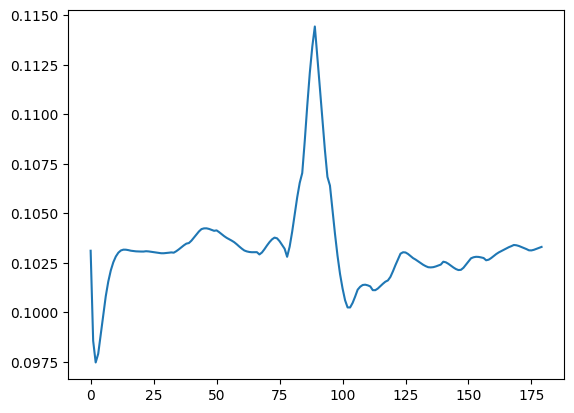

In [15]:
plt.plot(decoded_gen[123])